<a href="https://colab.research.google.com/github/Ayanlola2002/Data-Science-Nigeria/blob/master/developing_Staff_promotion_algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle

In [0]:
!chmod 600 /root/.kaggle/kaggle.json

In [496]:
!kaggle competitions download -c intercampusai2019

sample_submission2.csv: Skipping, found more recently modified local copy (use --force to force download)
test.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
#unzippig the us-data file
from shutil import unpack_archive
#unpack_archive('all.zip')
unpack_archive('train.csv.zip')
unpack_archive('test.csv.zip')

In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

In [0]:
from scipy import stats
from scipy.stats import norm, skew #for some statistics

In [0]:
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points

In [0]:
#train = pd.read_csv('train.csv',parse_dates=[['weblog_date'],['date_of_advert'],['last_advert_online']])
#test = pd.read_csv('test.csv',parse_dates=[weblog_date],[[date_of_advert],[last_advert_online])
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [0]:
sample=pd.read_csv('sample_submission2.csv')

In [504]:
sample.head()

,EmployeeNo,Promoted_or_Not
0,YAK/S/34385,1
1,YAK/S/27825,1
2,YAK/S/23870,1
3,YAK/S/54784,1
4,YAK/S/25058,1


In [0]:
train_copy=train.copy()
test_copy=test.copy()

In [506]:
##display the first five rows of the train dataset.
train.head()

,EmployeeNo,Division,Qualification,Gender,Channel_of_Recruitment,Trainings_Attended,Year_of_birth,Last_performance_score,Year_of_recruitment,Targets_met,Previous_Award,Training_score_average,State_Of_Origin,Foreign_schooled,Marital_Status,Past_Disciplinary_Action,Previous_IntraDepartmental_Movement,No_of_previous_employers,Promoted_or_Not
0,YAK/S/00001,Commercial Sales and Marketing,"MSc, MBA and PhD",Female,Direct Internal process,2,1986,12.500,2011,1,0,41,ANAMBRA,No,Married,No,No,0,0
1,YAK/S/00002,Customer Support and Field Operations,First Degree or HND,Male,Agency and others,2,1991,12.500,2015,0,0,52,ANAMBRA,Yes,Married,No,No,0,0
2,YAK/S/00003,Commercial Sales and Marketing,First Degree or HND,Male,Direct Internal process,2,1987,7.500,2012,0,0,42,KATSINA,Yes,Married,No,No,0,0
3,YAK/S/00004,Commercial Sales and Marketing,First Degree or HND,Male,Agency and others,3,1982,2.500,2009,0,0,42,NIGER,Yes,Single,No,No,1,0
4,YAK/S/00006,Information and Strategy,First Degree or HND,Male,Direct Internal process,3,1990,7.500,2012,0,0,77,AKWA IBOM,Yes,Married,No,No,1,0


In [507]:
##display the first five rows of the test dataset.
test.head()

,EmployeeNo,Division,Qualification,Gender,Channel_of_Recruitment,Trainings_Attended,Year_of_birth,Last_performance_score,Year_of_recruitment,Targets_met,Previous_Award,Training_score_average,State_Of_Origin,Foreign_schooled,Marital_Status,Past_Disciplinary_Action,Previous_IntraDepartmental_Movement,No_of_previous_employers
0,YAK/S/00005,Information Technology and Solution Support,First Degree or HND,Male,Agency and others,2,1976,7.500,2017,0,0,65,FCT,Yes,Married,No,No,1
1,YAK/S/00011,Information Technology and Solution Support,NaN,Male,Direct Internal process,2,1991,0.000,2018,0,0,69,OGUN,Yes,Married,No,No,1
2,YAK/S/00015,Research and Innovation,"MSc, MBA and PhD",Male,Direct Internal process,2,1984,7.500,2012,0,0,76,KANO,Yes,Married,No,No,1
3,YAK/S/00016,Customer Support and Field Operations,First Degree or HND,Male,Agency and others,2,1984,2.500,2009,0,0,52,RIVERS,No,Single,No,No,1
4,YAK/S/00017,Information Technology and Solution Support,First Degree or HND,Male,Agency and others,2,1983,7.500,2014,1,0,69,FCT,Yes,Married,No,No,0


In [509]:
#check the numbers of samples and features
print("The train data size before dropping Id feature is : {} ".format(train.shape))
print("The test data size before dropping Id feature is : {} ".format(test.shape))

The train data size before dropping Id feature is : (38312, 19) 
The test data size before dropping Id feature is : (16496, 18) 


In [0]:
#Save the 'Id' column
train_ID = train['EmployeeNo']
test_ID = test['EmployeeNo']

In [0]:
#Now drop the  'Id' colum since it's unnecessary for  the prediction process.
train.drop("EmployeeNo", axis = 1, inplace = True)
test.drop("EmployeeNo", axis = 1, inplace = True)

In [0]:
#save and drop the target varriable
y_train=train['Promoted_or_Not']

In [513]:
y_train.value_counts()

0    35071
1     3241
Name: Promoted_or_Not, dtype: int64

In [0]:
#dropping the target varriable
train.drop('Promoted_or_Not',axis=1,inplace=True)

In [515]:
train.dtypes

Division                                object
Qualification                           object
Gender                                  object
Channel_of_Recruitment                  object
Trainings_Attended                       int64
Year_of_birth                            int64
Last_performance_score                 float64
Year_of_recruitment                      int64
Targets_met                              int64
Previous_Award                           int64
Training_score_average                   int64
State_Of_Origin                         object
Foreign_schooled                        object
Marital_Status                          object
Past_Disciplinary_Action                object
Previous_IntraDepartmental_Movement     object
No_of_previous_employers                object
dtype: object

In [0]:
#separate categorical varriable from numerical varriable
quantitative = [f for f in train.columns if train.dtypes[f] != 'object']
#quantitative.remove('SalePrice')
#quantitative.remove('Id')
qualitative = [f for f in train.columns if train.dtypes[f] == 'object']

In [519]:
quantitative

['Trainings_Attended',
 'Year_of_birth',
 'Last_performance_score',
 'Year_of_recruitment',
 'Targets_met',
 'Previous_Award',
 'Training_score_average']

In [521]:
qualitative

['Division',
 'Qualification',
 'Gender',
 'Channel_of_Recruitment',
 'State_Of_Origin',
 'Foreign_schooled',
 'Marital_Status',
 'Past_Disciplinary_Action',
 'Previous_IntraDepartmental_Movement',
 'No_of_previous_employers']

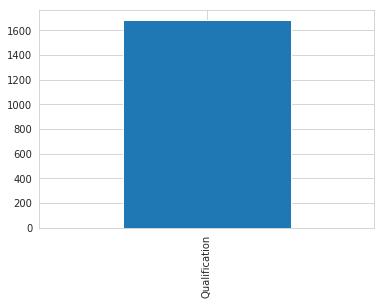

In [522]:
#missing values
sns.set_style("whitegrid")
missing = train.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()

In [523]:
# check number & percentage of missing value in the columns
def missing_values_table(df):
  mis_val = df.isnull().sum() #total missing values
  mis_val_percent = 100 * df.isnull().sum() / len(df) #percentage of missing values
  mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1) #make a table with the results
  mis_val_table_ren_columns = mis_val_table.rename(
  columns = {0 : 'Missing Values', 1 : '% of Total Values'}) #rename the columns
     # sort the table by percentage of missing value
  mis_val_table_ren_columns = mis_val_table_ren_columns[
  mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)

        #print same summary information
  print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")

          # return the dataframe with missing information
  return mis_val_table_ren_columns
  
missing_values = missing_values_table(train)
missing_values.head()

Your selected dataframe has 17 columns.
There are 1 columns that have missing values.


,Missing Values,% of Total Values
Qualification,1679,4.400


In [0]:
cols_with_missing = [col for col in train.columns if train[col].isnull().any()]

reduced_train =train.drop(cols_with_missing, axis=1)
reduced_test = test.drop(cols_with_missing, axis=1)

In [440]:
#Handling missing values
train['Qualification'].unique()

array(['MSc, MBA and PhD', 'First Degree or HND', nan,
       'Non-University Education'], dtype=object)

In [0]:
train['Qualification'].fillna('uncertified',inplace=True)
test['Qualification'].fillna('uncertified',inplace=True)

In [0]:
def School_rank(Foreign_schooled,Qualification):
  if Foreign_schooled == 'Yes' and Qualification == 'MSc, MBA and PhD':
    return 5
  if Foreign_schooled == 'Yes' and Qualification == 'First Degree or HND':
    return 4
  if Foreign_schooled == 'No' and Qualification == 'MSc, MBA and PhD':
    return 3
  if Foreign_schooled == 'No' and Qualification == 'First Degree or HND':
    return 2
  else:
    return 1

In [0]:
#we could add hirarchical feature of people that foreigned schooled and PHD:4,with First degree :3,Local(PHD):3,Local Bsc:2,uneducated:1,noinfo:1 
train['School_rank']=train.apply(lambda x:School_rank(x['Foreign_schooled'],x['Qualification']),axis=1)
test['School_rank']=train.apply(lambda x:School_rank(x['Foreign_schooled'],x['Qualification']),axis=1)

In [444]:
train['School_rank'].value_counts()

4    23334
5     9591
1     2265
2     2244
3      878
Name: School_rank, dtype: int64

In [0]:
'''def ConvertQualificationToFeature(desc):
  Qualification={
      'MSc, MBA and PhD':5,
      'First Degree or HND':3,
      'Non-University Education':1,
      'uncertified':1
      }
  return Qualification[desc]'''

In [0]:
#train['Qualification']=train['Qualification'].apply(ConvertQualificationToFeature)
#test['Qualification']=test['Qualification'].apply(ConvertQualificationToFeature)

In [445]:
train.head()
#qualification done

,Division,Qualification,Gender,Channel_of_Recruitment,Trainings_Attended,Year_of_birth,Last_performance_score,Year_of_recruitment,Targets_met,Previous_Award,Training_score_average,State_Of_Origin,Foreign_schooled,Marital_Status,Past_Disciplinary_Action,Previous_IntraDepartmental_Movement,No_of_previous_employers,School_rank
0,Commercial Sales and Marketing,"MSc, MBA and PhD",Female,Direct Internal process,2,1986,12.500,2011,1,0,41,ANAMBRA,No,Married,No,No,0,3
1,Customer Support and Field Operations,First Degree or HND,Male,Agency and others,2,1991,12.500,2015,0,0,52,ANAMBRA,Yes,Married,No,No,0,4
2,Commercial Sales and Marketing,First Degree or HND,Male,Direct Internal process,2,1987,7.500,2012,0,0,42,KATSINA,Yes,Married,No,No,0,4
3,Commercial Sales and Marketing,First Degree or HND,Male,Agency and others,3,1982,2.500,2009,0,0,42,NIGER,Yes,Single,No,No,1,4
4,Information and Strategy,First Degree or HND,Male,Direct Internal process,3,1990,7.500,2012,0,0,77,AKWA IBOM,Yes,Married,No,No,1,4


In [446]:
train['Gender'].unique()

array(['Female', 'Male'], dtype=object)

In [447]:
#one hot encode gender since it does not show hirarchy male cant be said to be more importance than female
train['Gender'].value_counts()

Male      26880
Female    11432
Name: Gender, dtype: int64

In [448]:
#one hot encode
train['Division'].value_counts()

Commercial Sales and Marketing                 11695
Customer Support and Field Operations           7973
Sourcing and Purchasing                         5052
Information Technology and Solution Support     4952
Information and Strategy                        3721
Business Finance Operations                     1786
People/HR Management                            1704
Regulatory and Legal services                    733
Research and Innovation                          696
Name: Division, dtype: int64

In [449]:
train['Division'].unique()

array(['Commercial Sales and Marketing',
       'Customer Support and Field Operations',
       'Information and Strategy',
       'Information Technology and Solution Support',
       'Sourcing and Purchasing', 'Business Finance Operations',
       'People/HR Management', 'Research and Innovation',
       'Regulatory and Legal services'], dtype=object)

In [0]:
def ConvertDivisionToFeature(desc):
  Division={
      'Commercial Sales and Marketing':'CSM',
      'Customer Support and Field Operations':'CSFO',
      'Information and Strategy':'IS',
      'Information Technology and Solution Support':'ITSS',
      'Sourcing and Purchasing':'SP',
      'Business Finance Operations':'BFO',
      'People/HR Management':'PHM',
      'Research and Innovation':'RI',
      'Regulatory and Legal services':'RLS'
      }
  return Division[desc]

In [0]:
train['Division']=train['Division'].apply(ConvertDivisionToFeature)
test['Division']=test['Division'].apply(ConvertDivisionToFeature)

In [452]:
train.head()

,Division,Qualification,Gender,Channel_of_Recruitment,Trainings_Attended,Year_of_birth,Last_performance_score,Year_of_recruitment,Targets_met,Previous_Award,Training_score_average,State_Of_Origin,Foreign_schooled,Marital_Status,Past_Disciplinary_Action,Previous_IntraDepartmental_Movement,No_of_previous_employers,School_rank
0,CSM,"MSc, MBA and PhD",Female,Direct Internal process,2,1986,12.500,2011,1,0,41,ANAMBRA,No,Married,No,No,0,3
1,CSFO,First Degree or HND,Male,Agency and others,2,1991,12.500,2015,0,0,52,ANAMBRA,Yes,Married,No,No,0,4
2,CSM,First Degree or HND,Male,Direct Internal process,2,1987,7.500,2012,0,0,42,KATSINA,Yes,Married,No,No,0,4
3,CSM,First Degree or HND,Male,Agency and others,3,1982,2.500,2009,0,0,42,NIGER,Yes,Single,No,No,1,4
4,IS,First Degree or HND,Male,Direct Internal process,3,1990,7.500,2012,0,0,77,AKWA IBOM,Yes,Married,No,No,1,4


In [453]:
#one encode
train['Channel_of_Recruitment'].value_counts()

Agency and others                  21310
Direct Internal process            16194
Referral and Special candidates      808
Name: Channel_of_Recruitment, dtype: int64

In [454]:
train['Channel_of_Recruitment'].unique()

array(['Direct Internal process', 'Agency and others',
       'Referral and Special candidates'], dtype=object)

In [0]:
def convertChannelToFeature(desc):
  Channel={
      'Direct Internal process':'DIP',
      'Agency and others':'AO',
      'Referral and Special candidates':'RSC'
      }
  return Channel[desc]

In [0]:
train['Channel_of_Recruitment']=train['Channel_of_Recruitment'].apply(convertChannelToFeature)
test['Channel_of_Recruitment']=test['Channel_of_Recruitment'].apply(convertChannelToFeature)

In [457]:
train.head()

,Division,Qualification,Gender,Channel_of_Recruitment,Trainings_Attended,Year_of_birth,Last_performance_score,Year_of_recruitment,Targets_met,Previous_Award,Training_score_average,State_Of_Origin,Foreign_schooled,Marital_Status,Past_Disciplinary_Action,Previous_IntraDepartmental_Movement,No_of_previous_employers,School_rank
0,CSM,"MSc, MBA and PhD",Female,DIP,2,1986,12.500,2011,1,0,41,ANAMBRA,No,Married,No,No,0,3
1,CSFO,First Degree or HND,Male,AO,2,1991,12.500,2015,0,0,52,ANAMBRA,Yes,Married,No,No,0,4
2,CSM,First Degree or HND,Male,DIP,2,1987,7.500,2012,0,0,42,KATSINA,Yes,Married,No,No,0,4
3,CSM,First Degree or HND,Male,AO,3,1982,2.500,2009,0,0,42,NIGER,Yes,Single,No,No,1,4
4,IS,First Degree or HND,Male,DIP,3,1990,7.500,2012,0,0,77,AKWA IBOM,Yes,Married,No,No,1,4


In [458]:
qualitative

['Division',
 'Qualification',
 'Gender',
 'Channel_of_Recruitment',
 'State_Of_Origin',
 'Foreign_schooled',
 'Marital_Status',
 'Past_Disciplinary_Action',
 'Previous_IntraDepartmental_Movement',
 'No_of_previous_employers']

In [459]:
train['State_Of_Origin'].value_counts()

LAGOS          6204
FCT            2389
OGUN           2302
RIVERS         2222
ANAMBRA        1710
KANO           1649
DELTA          1594
OYO            1508
KADUNA         1399
IMO            1307
EDO            1259
ENUGU          1025
ABIA            950
OSUN            929
ONDO            875
NIGER           857
KWARA           765
PLATEAU         739
AKWA IBOM       673
NASSARAWA       632
KATSINA         615
ADAMAWA         605
BENUE           579
BAUCHI          557
KOGI            542
SOKOTO          499
CROSS RIVER     495
EKITI           455
BORNO           447
TARABA          400
KEBBI           393
BAYELSA         324
EBONYI          313
GOMBE           291
ZAMFARA         290
JIGAWA          262
YOBE            257
Name: State_Of_Origin, dtype: int64

In [0]:
#categorized into six geo-political zones
def ConvertToGeoPoliticalZone(desc):
  
  State={
      
      'BENUE':'NC',
      'KOGI':'NC',
      'KWARA':'NC',
      'NASSARAWA':'NC',
      'NIGER':'NC',
      'PLATEAU':'NC',
      'FCT':'NC',
      
      'ADAMAWA':'NE',
      'BAUCHI':'NE',
      'BORNO':'NE',
      'GOMBE':'NE',
      'TARABA':'NE',
      'YOBE':'NE',
      
      
          
      'JIGAWA':'NW',
      'KADUNA':'NW',
      'KANO':'NW',
      'KATSINA':'NW',
      'KEBBI':'NW',
      'SOKOTO':'NW',
      'ZAMFARA':'NW',
      
          
      'ABIA':'SE',
      'ANAMBRA':'SE',
      'EBONYI':'SE',
      'ENUGU':'SE',
      'IMO':'SE',
      
      'AKWA IBOM':'SS',
      'BAYELSA':'SS',
      'CROSS RIVER':'SS',
      'RIVERS':'SS',
      'DELTA':'SS',
      'EDO':'SS',
     
        
      'EKITI':'SW',
      'LAGOS':'SW',
      'OGUN':'SW',
      'ONDO':'SW',
      'OSUN':'SW',
      'OYO':'SW'
      }
  return State[desc]

In [0]:
#one hot encode
train['State_Of_Origin']=train['State_Of_Origin'].apply(ConvertToGeoPoliticalZone)
test['State_Of_Origin']=test['State_Of_Origin'].apply(ConvertToGeoPoliticalZone)

In [462]:
train.head()

,Division,Qualification,Gender,Channel_of_Recruitment,Trainings_Attended,Year_of_birth,Last_performance_score,Year_of_recruitment,Targets_met,Previous_Award,Training_score_average,State_Of_Origin,Foreign_schooled,Marital_Status,Past_Disciplinary_Action,Previous_IntraDepartmental_Movement,No_of_previous_employers,School_rank
0,CSM,"MSc, MBA and PhD",Female,DIP,2,1986,12.500,2011,1,0,41,SE,No,Married,No,No,0,3
1,CSFO,First Degree or HND,Male,AO,2,1991,12.500,2015,0,0,52,SE,Yes,Married,No,No,0,4
2,CSM,First Degree or HND,Male,DIP,2,1987,7.500,2012,0,0,42,NW,Yes,Married,No,No,0,4
3,CSM,First Degree or HND,Male,AO,3,1982,2.500,2009,0,0,42,NC,Yes,Single,No,No,1,4
4,IS,First Degree or HND,Male,DIP,3,1990,7.500,2012,0,0,77,SS,Yes,Married,No,No,1,4


In [463]:
#hirarchy coding 2,1 
#one hot encode first later perform hirarchical encoding
train['Foreign_schooled'].value_counts()

Yes    34995
No      3317
Name: Foreign_schooled, dtype: int64

In [464]:
#one ehot encode
train['Marital_Status'].value_counts()

Married     31022
Single       6927
Not_Sure      363
Name: Marital_Status, dtype: int64

In [465]:
#Do Hirarchical encoding NO:1  ,yes :0
train['Past_Disciplinary_Action'].value_counts()

No     38161
Yes      151
Name: Past_Disciplinary_Action, dtype: int64

In [0]:
'''def ConvertDisciplinaryToFeature(desc):
  DisciplinaryAction={
      'Yes':0,
      'No':1
      
  }
  return DisciplinaryAction[desc]'''

In [0]:
#it is logical to rate those without dicsciplinary action higher than those that have
#train['Past_Disciplinary_Action']=train['Past_Disciplinary_Action'].apply(ConvertDisciplinaryToFeature)
#test['Past_Disciplinary_Action']=test['Past_Disciplinary_Action'].apply(ConvertDisciplinaryToFeature)

In [466]:
train.head()

,Division,Qualification,Gender,Channel_of_Recruitment,Trainings_Attended,Year_of_birth,Last_performance_score,Year_of_recruitment,Targets_met,Previous_Award,Training_score_average,State_Of_Origin,Foreign_schooled,Marital_Status,Past_Disciplinary_Action,Previous_IntraDepartmental_Movement,No_of_previous_employers,School_rank
0,CSM,"MSc, MBA and PhD",Female,DIP,2,1986,12.500,2011,1,0,41,SE,No,Married,No,No,0,3
1,CSFO,First Degree or HND,Male,AO,2,1991,12.500,2015,0,0,52,SE,Yes,Married,No,No,0,4
2,CSM,First Degree or HND,Male,DIP,2,1987,7.500,2012,0,0,42,NW,Yes,Married,No,No,0,4
3,CSM,First Degree or HND,Male,AO,3,1982,2.500,2009,0,0,42,NC,Yes,Single,No,No,1,4
4,IS,First Degree or HND,Male,DIP,3,1990,7.500,2012,0,0,77,SS,Yes,Married,No,No,1,4


In [0]:
'''def Previous_IntraDepartmental_Movement(desc):
  Movement={
      'Yes':1,
      'No':0
      
  }
  return Movement[desc]'''

In [467]:

#You might want to try rating those with more intra deptmental movement high cos looks like they might understand the flow of the business more
#will try one hot encoding first
train['Previous_IntraDepartmental_Movement'].value_counts()

No     34709
Yes     3603
Name: Previous_IntraDepartmental_Movement, dtype: int64

In [0]:
#train['Previous_IntraDepartmental_Movement']=train['Previous_IntraDepartmental_Movement'].apply(Previous_IntraDepartmental_Movement)
#test['Previous_IntraDepartmental_Movement']=test['Previous_IntraDepartmental_Movement'].apply(Previous_IntraDepartmental_Movement)

In [468]:
train.head()

,Division,Qualification,Gender,Channel_of_Recruitment,Trainings_Attended,Year_of_birth,Last_performance_score,Year_of_recruitment,Targets_met,Previous_Award,Training_score_average,State_Of_Origin,Foreign_schooled,Marital_Status,Past_Disciplinary_Action,Previous_IntraDepartmental_Movement,No_of_previous_employers,School_rank
0,CSM,"MSc, MBA and PhD",Female,DIP,2,1986,12.500,2011,1,0,41,SE,No,Married,No,No,0,3
1,CSFO,First Degree or HND,Male,AO,2,1991,12.500,2015,0,0,52,SE,Yes,Married,No,No,0,4
2,CSM,First Degree or HND,Male,DIP,2,1987,7.500,2012,0,0,42,NW,Yes,Married,No,No,0,4
3,CSM,First Degree or HND,Male,AO,3,1982,2.500,2009,0,0,42,NC,Yes,Single,No,No,1,4
4,IS,First Degree or HND,Male,DIP,3,1990,7.500,2012,0,0,77,SS,Yes,Married,No,No,1,4


In [0]:
def ConvertNumberOfPreviousEmployerFeature(desc):
  Past={
      '0':'0',
      '1':'1',
      '2':'2',
      '3':'3',
      '4':'4',
      '5':'5',
      'More than 5':'7'
      }
  return Past[desc]

In [470]:

train['No_of_previous_employers'].value_counts()

1              18867
0              13272
2               1918
3               1587
4               1324
5                943
More than 5      401
Name: No_of_previous_employers, dtype: int64

In [471]:
train['No_of_previous_employers'].unique()

array(['0', '1', '4', '3', '2', 'More than 5', '5'], dtype=object)

In [0]:
#This column is not actually numerical col change to numerical and retry for other models like LGB,XGboost,Randomforest
train['No_of_previous_employers']=train['No_of_previous_employers'].apply(ConvertNumberOfPreviousEmployerFeature)
test['No_of_previous_employers']=test['No_of_previous_employers'].apply(ConvertNumberOfPreviousEmployerFeature)

In [473]:
train.head()

,Division,Qualification,Gender,Channel_of_Recruitment,Trainings_Attended,Year_of_birth,Last_performance_score,Year_of_recruitment,Targets_met,Previous_Award,Training_score_average,State_Of_Origin,Foreign_schooled,Marital_Status,Past_Disciplinary_Action,Previous_IntraDepartmental_Movement,No_of_previous_employers,School_rank
0,CSM,"MSc, MBA and PhD",Female,DIP,2,1986,12.500,2011,1,0,41,SE,No,Married,No,No,0,3
1,CSFO,First Degree or HND,Male,AO,2,1991,12.500,2015,0,0,52,SE,Yes,Married,No,No,0,4
2,CSM,First Degree or HND,Male,DIP,2,1987,7.500,2012,0,0,42,NW,Yes,Married,No,No,0,4
3,CSM,First Degree or HND,Male,AO,3,1982,2.500,2009,0,0,42,NC,Yes,Single,No,No,1,4
4,IS,First Degree or HND,Male,DIP,3,1990,7.500,2012,0,0,77,SS,Yes,Married,No,No,1,4


In [474]:
#no of years spent in establishment can be calculated
train['Year_of_recruitment'].value_counts()

2016    4916
2015    4757
2017    4656
2014    4101
2012    3909
2013    3314
2018    3194
2011    2011
2010    1865
2009    1497
2008     619
2007     570
2006     472
2004     422
2003     394
2005     376
2002     293
2001     269
2000     230
1999      90
1998      53
1995      51
1996      46
1997      38
1994      35
1993      27
1990      22
1991      21
1992      20
1988      13
1989      11
1987       8
1986       7
1985       4
1982       1
Name: Year_of_recruitment, dtype: int64

In [475]:
#age feature could be added
train['Year_of_birth'].value_counts()

1991    2544
1990    2506
1989    2441
1992    2380
1988    2268
1993    2217
1987    2157
1994    1985
1986    1882
1985    1766
1984    1505
1995    1416
1983    1342
1982    1195
1981    1162
1996     910
1980     893
1979     797
1978     685
1977     600
1997     596
1976     551
1975     508
1973     397
1974     394
1971     353
1972     312
1998     305
1970     256
1969     249
1968     233
1966     207
1967     195
1965     178
1964     168
1999     167
1963     161
1961     147
1962     134
2001      71
2000      66
1957       4
1958       3
1960       1
1959       1
1956       1
1955       1
1950       1
1952       1
Name: Year_of_birth, dtype: int64

In [0]:
from datetime import date
def CalculateYear(year):
  today=date.today()
  age=today.year-year
  return age


In [0]:
train['No_Of_Year_Spent']=train['Year_of_recruitment'].apply(CalculateYear)
test['No_Of_Year_Spent']=test['Year_of_recruitment'].apply(CalculateYear)

In [0]:
train['Age_in_years']=train['Year_of_birth'].apply(CalculateYear)
test['Age_in_years']=test['Year_of_birth'].apply(CalculateYear)

In [479]:
train.head()


,Division,Qualification,Gender,Channel_of_Recruitment,Trainings_Attended,Year_of_birth,Last_performance_score,Year_of_recruitment,Targets_met,Previous_Award,Training_score_average,State_Of_Origin,Foreign_schooled,Marital_Status,Past_Disciplinary_Action,Previous_IntraDepartmental_Movement,No_of_previous_employers,School_rank,No_Of_Year_Spent,Age_in_years
0,CSM,"MSc, MBA and PhD",Female,DIP,2,1986,12.500,2011,1,0,41,SE,No,Married,No,No,0,3,8,33
1,CSFO,First Degree or HND,Male,AO,2,1991,12.500,2015,0,0,52,SE,Yes,Married,No,No,0,4,4,28
2,CSM,First Degree or HND,Male,DIP,2,1987,7.500,2012,0,0,42,NW,Yes,Married,No,No,0,4,7,32
3,CSM,First Degree or HND,Male,AO,3,1982,2.500,2009,0,0,42,NC,Yes,Single,No,No,1,4,10,37
4,IS,First Degree or HND,Male,DIP,3,1990,7.500,2012,0,0,77,SS,Yes,Married,No,No,1,4,7,29


In [0]:
#dropping Year_of_recruitment and Year_of_birth
train.drop('Year_of_recruitment', axis = 1, inplace = True)
test.drop('Year_of_recruitment', axis = 1, inplace = True)

train.drop('Year_of_birth', axis = 1, inplace = True)
test.drop('Year_of_birth', axis = 1, inplace = True)


In [481]:
train.head()

,Division,Qualification,Gender,Channel_of_Recruitment,Trainings_Attended,Last_performance_score,Targets_met,Previous_Award,Training_score_average,State_Of_Origin,Foreign_schooled,Marital_Status,Past_Disciplinary_Action,Previous_IntraDepartmental_Movement,No_of_previous_employers,School_rank,No_Of_Year_Spent,Age_in_years
0,CSM,"MSc, MBA and PhD",Female,DIP,2,12.500,1,0,41,SE,No,Married,No,No,0,3,8,33
1,CSFO,First Degree or HND,Male,AO,2,12.500,0,0,52,SE,Yes,Married,No,No,0,4,4,28
2,CSM,First Degree or HND,Male,DIP,2,7.500,0,0,42,NW,Yes,Married,No,No,0,4,7,32
3,CSM,First Degree or HND,Male,AO,3,2.500,0,0,42,NC,Yes,Single,No,No,1,4,10,37
4,IS,First Degree or HND,Male,DIP,3,7.500,0,0,77,SS,Yes,Married,No,No,1,4,7,29


In [482]:
train.dtypes

Division                                object
Qualification                           object
Gender                                  object
Channel_of_Recruitment                  object
Trainings_Attended                       int64
Last_performance_score                 float64
Targets_met                              int64
Previous_Award                           int64
Training_score_average                   int64
State_Of_Origin                         object
Foreign_schooled                        object
Marital_Status                          object
Past_Disciplinary_Action                object
Previous_IntraDepartmental_Movement     object
No_of_previous_employers                object
School_rank                              int64
No_Of_Year_Spent                         int64
Age_in_years                             int64
dtype: object

In [0]:
train['Last_performance_score']=train['Last_performance_score'].round().astype(int)


In [484]:
train.dtypes

Division                               object
Qualification                          object
Gender                                 object
Channel_of_Recruitment                 object
Trainings_Attended                      int64
Last_performance_score                  int64
Targets_met                             int64
Previous_Award                          int64
Training_score_average                  int64
State_Of_Origin                        object
Foreign_schooled                       object
Marital_Status                         object
Past_Disciplinary_Action               object
Previous_IntraDepartmental_Movement    object
No_of_previous_employers               object
School_rank                             int64
No_Of_Year_Spent                        int64
Age_in_years                            int64
dtype: object

In [360]:

'''0 Division                                object
1 Qualification                           int64
2 Gender                                  object
3 Channel_of_Recruitment                  object
4 Trainings_Attended     *                  int64
5 Last_performance_score *               float64
6 Targets_met     *                         int64
7 Previous_Award    *                       int64
8 Training_score_average  *                 int64
9 State_Of_Origin                         object
10 Foreign_schooled                        object
11 Marital_Status                          object
12 Past_Disciplinary_Action                 int64
13 Previous_IntraDepartmental_Movement      int64
14 No_of_previous_employers                 int64
15 No_Of_Year_Spent  *                       int64
16 Age_in_years  *'''

[0,1,2,3,9,10,11,12,13,14]

[0, 1, 2, 3, 9, 10, 11, 12, 13, 14]

In [361]:
['Trainings_Attended',
 'Year_of_birth',
 'Last_performance_score',
 'Year_of_recruitment',
 'Targets_met',
 'Previous_Award',
 'Training_score_average']

['Trainings_Attended',
 'Year_of_birth',
 'Last_performance_score',
 'Year_of_recruitment',
 'Targets_met',
 'Previous_Award',
 'Training_score_average']

In [485]:
qualitative

['Division',
 'Qualification',
 'Gender',
 'Channel_of_Recruitment',
 'State_Of_Origin',
 'Foreign_schooled',
 'Marital_Status',
 'Past_Disciplinary_Action',
 'Previous_IntraDepartmental_Movement',
 'No_of_previous_employers']

In [0]:
#extracting the index of categorical varriable
#categorical_var = np.where((train.dtypes != np.float)&(train.dtypes != np.int))[0]
#train.dtypes[f] != 'object']

In [0]:
#categorical_var

In [0]:
#one hot encode categorical varribles

qualitative_new=['Division',
 'Qualification',
 'Gender',
 'Channel_of_Recruitment',
 'State_Of_Origin',
 'Foreign_schooled',
 'Marital_Status',
 'Past_Disciplinary_Action',
 'Previous_IntraDepartmental_Movement',
  'No_of_previous_employers'
  ]

for column in qualitative_new :
    dummies = pd.get_dummies(train[column], prefix=column[:5])
    train = pd.concat([train, dummies], axis=1)

for column in qualitative_new:
    dummies = pd.get_dummies(test[column], prefix=column[:5])
    test = pd.concat([test, dummies], axis=1)

In [487]:
train.dtypes

Division                               object
Qualification                          object
Gender                                 object
Channel_of_Recruitment                 object
Trainings_Attended                      int64
Last_performance_score                  int64
Targets_met                             int64
Previous_Award                          int64
Training_score_average                  int64
State_Of_Origin                        object
Foreign_schooled                       object
Marital_Status                         object
Past_Disciplinary_Action               object
Previous_IntraDepartmental_Movement    object
No_of_previous_employers               object
School_rank                             int64
No_Of_Year_Spent                        int64
Age_in_years                            int64
Divis_BFO                               uint8
Divis_CSFO                              uint8
Divis_CSM                               uint8
Divis_IS                          

In [0]:
#drop all categorical column
train.drop(qualitative_new,axis=1,inplace=True)

In [0]:
test.drop(qualitative_new,axis=1,inplace=True)

In [0]:
#train.drop('Qualification',axis=1,inplace=True)
#test.drop('Qualification',axis=1,inplace=True)

In [271]:
#converting from uint8 to int64
'''train[['Divis_BFO',
       'Divis_CSFO',
       'Divis_CSM','Divis_IS',
       'Divis_ITSS',
       'Divis_PHM',
       'Divis_RI',
       'Divis_RLS',
       'Divis_SP',                                
       'Gende_Female',                            
       'Gende_Male',                              
       'Chann_AO',                               
       'Chann_DIP',                             
       'Chann_RSC',                               
       'State_NC',                               
       'State_NE',                                
       'State_NW',                               
       'State_SE',                               
       'State_SS',                               
       'State_SW',                                
       'Forei_No',                               
       'Forei_Yes',                              
       'Marit_Married',                           
       'Marit_Not_Sure',                         
       'Marit_Single']].astype(np.int64)'''

"train[['Divis_BFO',\n       'Divis_CSFO',\n       'Divis_CSM','Divis_IS',\n       'Divis_ITSS',\n       'Divis_PHM',\n       'Divis_RI',\n       'Divis_RLS',\n       'Divis_SP',                                \n       'Gende_Female',                            \n       'Gende_Male',                              \n       'Chann_AO',                               \n       'Chann_DIP',                             \n       'Chann_RSC',                               \n       'State_NC',                               \n       'State_NE',                                \n       'State_NW',                               \n       'State_SE',                               \n       'State_SS',                               \n       'State_SW',                                \n       'Forei_No',                               \n       'Forei_Yes',                              \n       'Marit_Married',                           \n       'Marit_Not_Sure',                         \n       'Marit_Sing

In [491]:
train.dtypes

Trainings_Attended                int64
Last_performance_score            int64
Targets_met                       int64
Previous_Award                    int64
Training_score_average            int64
School_rank                       int64
No_Of_Year_Spent                  int64
Age_in_years                      int64
Divis_BFO                         uint8
Divis_CSFO                        uint8
Divis_CSM                         uint8
Divis_IS                          uint8
Divis_ITSS                        uint8
Divis_PHM                         uint8
Divis_RI                          uint8
Divis_RLS                         uint8
Divis_SP                          uint8
Quali_First Degree or HND         uint8
Quali_MSc, MBA and PhD            uint8
Quali_Non-University Education    uint8
Quali_uncertified                 uint8
Gende_Female                      uint8
Gende_Male                        uint8
Chann_AO                          uint8
Chann_DIP                         uint8


In [0]:
#train

In [0]:
'''
0-Qualification  *                        int64
1-Trainings_Attended                     int64
2-Last_performance_score                 int64
3-Targets_met    *                        int64
4-Previous_Award  *                       int64
5-Training_score_average                 int64
6-Past_Disciplinary_Action  *             int64
7-Previous_IntraDepartmental_Movement *   int64
8-No_of_previous_employers               int64
9-No_Of_Year_Spent                       int64
10-Age_in_years                           int64
Divis_BFO                              int64
Divis_CSFO                             int64
Divis_CSM                              int64
Divis_IS                               int64
Divis_ITSS                             int64
Divis_PHM                              int64
Divis_RI                               int64
Divis_RLS                              int64
Divis_SP                               int64
Gende_Female                           int64
Gende_Male                             int64
Chann_AO                               int64
Chann_DIP                              int64
Chann_RSC                              int64
State_NC                               int64
State_NE                               int64
State_NW                               int64
State_SE                               int64
State_SS                               int64
State_SW                               int64
Forei_No                               int64
Forei_Yes                              int64
Marit_Married                          int64
Marit_Not_Sure                         int64
Marit_Single'''

[0,3,4,6,7]

['Division',
 'Qualification',
 'Gender',
 'Channel_of_Recruitment',
 'State_Of_Origin',
 'Foreign_schooled',
 'Marital_Status',
 'Past_Disciplinary_Action',
 'Previous_IntraDepartmental_Movement',
 'No_of_previous_employers']


['Division',
 'Qualification',
 'Gender',
 'Channel_of_Recruitment',
 'State_Of_Origin',
 'Foreign_schooled',
 'Marital_Status',
 'Past_Disciplinary_Action',
 'Previous_IntraDepartmental_Movement',
 'No_of_previous_employers']

In [0]:
#This column is actually categorical column change to category and retry with other algorithm
#train['Targets_met'].unique()

In [0]:
#This column is actually categorical column change to category and retry with other algorithm
#train['Previous_Award'].unique()

In [0]:
# applying SMOTE cos of  large difference between 0s and 1s in target varriable

#from imblearn.over_sampling import SMOTE

#x_resample, y_resample = SMOTE().fit_sample(train, y_train.values.ravel()) 

# checking the shape of x_resample and y_resample
#print("Shape of x:", x_resample.shape)
#print("Shape of y:", y_resample.shape)

In [84]:
# train and valid sets from train
#from sklearn.ensemble import RandomForestClassifier
#from sklearn.model_selection import train_test_split

#x_trn, x_valid, y_trn, y_valid = train_test_split(train, y_train, test_size = 0.2, random_state = 0)

# checking the shapes
print(x_trn.shape)
print(y_train.shape)
print(x_valid.shape)
print(y_valid.shape)

(30649, 36)
(38312,)
(7663, 36)
(7663,)


In [0]:
'''from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
x_trn = sc.fit_transform(x_trn)
x_valid = sc.transform(x_valid)
test = sc.transform(test)'''

In [85]:
#model_RF=RandomForestClassifier(n_estimators=200,random_state=200,max_features=0.5,min_samples_leaf=3,oob_score=True,n_jobs=-1)
#model_RF.fit(train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features=0.5, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=True, random_state=200, verbose=0,
                       warm_start=False)

In [86]:
#Our Score on Validation Data
#model_RF.score(x_valid,y_valid)

0.9577189090434556

In [0]:
#Prediction on Test Set
#predict_y_RF = model_RF.predict(test)

In [88]:
#Our Score on Training data
#model_RF.score(x_trn,y_trn)

0.9541257463538778

In [0]:
#Prepare our Submission file
#my_submission = pd.DataFrame({'EmployeeNo':test_ID, 'Promoted_or_Not': predict_y_RF })
#my_submission.to_csv('submission_ayanlola.csv', index=False)

In [90]:
#!kaggle competitions submit -c intercampusai2019 -f submission_ayanlola.csv -m "BOOTCAMP"

100% 226k/226k [00:00<00:00, 1.06MB/s]
Successfully submitted to Data Science Nigeria Staff Promotion Algorithm 

In [91]:
#!kaggle competitions submissions -c intercampusai2019

fileName                 date                 description  status    publicScore  privateScore  
-----------------------  -------------------  -----------  --------  -----------  ------------  
submission_ayanlola.csv  2019-10-19 21:02:37  BOOTCAMP     complete  0.94401      None          
submission_ayanlola.csv  2019-10-18 23:10:16  BOOTCAMP     complete  0.94401      None          
submission_ayanlola.csv  2019-10-17 15:07:53  BOOTCAMP     complete  0.94523      None          
submission_ayanlola.csv  2019-10-17 13:53:53  BOOTCAMP     complete  0.94361      None          
submission_ayanlola.csv  2019-10-16 23:41:51  BOOTCAMP     complete  0.00000      None          
submission_ayanlola.csv  2019-10-16 22:44:42  BOOTCAMP     complete  0.00000      None          
submission_ayanlola.csv  2019-10-15 23:27:06  BOOTCAMP     complete  0.94523      None          
submission_ayanlola.csv  2019-10-15 23:12:32  BOOTCAMP     complete  0.94159      None          
submission_ayanlola.csv  2019-

In [0]:
#Applying ADABoost
#from sklearn.ensemble import AdaBoostClassifier
#from sklearn.model_selection import train_test_split

#x_trn,x_valid, y_trn, y_valid = train_test_split(train,y_train, test_size = 0.2, random_state = 0)

In [0]:
#model_ada = AdaBoostClassifier()
#model_ada.fit(train,y_train)

In [0]:
#Our Score on Validation Data
#model_ada.score(x_valid,y_valid)

In [0]:
#Prediction on Test Set
#predict_y_ada = model_ada.predict(test)

In [0]:
#Our Score on Training data
#model_ada.score(x_trn,y_trn)

In [0]:
#Prepare our Submission file
#my_submission = pd.DataFrame({'EmployeeNo':test_ID, 'Promoted_or_Not': predict_y_ada })
#my_submission.to_csv('submission_ayanlola.csv', index=False)

In [0]:
#!kaggle competitions submit -c intercampusai2019 -f submission_ayanlola.csv -m "BOOTCAMP"

In [0]:
#!kaggle competitions submissions -c intercampusai2019

In [0]:
#Applying XGBOOST
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

x_trn,x_valid, y_trn, y_valid = train_test_split(train,y_train, test_size = 0.2, random_state = 0)

In [493]:
#parameter tuning
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

model_xg =XGBClassifier()
param_dist = {"max_depth": [3,5,7],
              "min_child_weight" : [1,3,6],
              "n_estimators": [140],
              "learning_rate": [0.05, 0.1,0.16],
              "gamma":[0]}
grid_search = GridSearchCV(model_xg, param_grid=param_dist, cv = 3, 
                                   verbose=10, n_jobs=-1)
grid_search.fit(train, y_train)

grid_search.best_estimator_

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   34.2s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   59.4s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:  7.2min finished


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=140, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [374]:
#Applying XGboost
model_xg =XGBClassifier(objective="binary:logistic", 
    learning_rate=0.1, 
    min_child_weight=1,
    max_depth=5, 
    gamma=0, 
    n_estimators=140)
model_xg.fit(train,y_train)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=140, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [0]:
'''model_xg =XGBClassifier(n_estimators=30,learning_rate =0.3,max_depth=3,
                        min_child_weight=1,gamma=0.3,subsample=0.8,colsample_bytree=0.8,
                        objective= 'binary:logistic',nthread=4,scale_pos_weight=1,reg_alpha=1e-05,
                        reg_lambda=1,seed=27)

model_xg.fit(train,y_train)'''

"model_xg =XGBClassifier(n_estimators=30,learning_rate =0.3,max_depth=3,\n                        min_child_weight=1,gamma=0.3,subsample=0.8,colsample_bytree=0.8,\n                        objective= 'binary:logistic',nthread=4,scale_pos_weight=1,reg_alpha=1e-05,\n                        reg_lambda=1,seed=27)\n\nmodel_xg.fit(train,y_train)"

In [375]:
#Our Score on Validation Data
model_xg.score(x_valid,y_valid)

0.9491060942189743

In [0]:
#Prediction on Test Set
predict_y_xg = model_xg.predict(test)

In [377]:
#Our Score on Training data
model_xg.score(x_trn,y_trn)

0.9437502039218245

In [0]:
#Prepare our Submission file
my_submission = pd.DataFrame({'EmployeeNo':test_ID, 'Promoted_or_Not': predict_y_xg })
my_submission.to_csv('submission_ayanlola.csv', index=False)

In [379]:
!kaggle competitions submit -c intercampusai2019 -f submission_ayanlola.csv -m "BOOTCAMP"

100% 226k/226k [00:00<00:00, 632kB/s]
Successfully submitted to Data Science Nigeria Staff Promotion Algorithm 

In [380]:
!kaggle competitions submissions -c intercampusai2019

fileName                 date                 description  status    publicScore  privateScore  
-----------------------  -------------------  -----------  --------  -----------  ------------  
submission_ayanlola.csv  2019-10-19 22:31:07  BOOTCAMP     complete  0.94421      None          
submission_ayanlola.csv  2019-10-19 21:29:58  BOOTCAMP     complete  0.94502      None          
submission_ayanlola.csv  2019-10-19 21:17:04  BOOTCAMP     complete  0.94502      None          
submission_ayanlola.csv  2019-10-19 21:02:37  BOOTCAMP     complete  0.94401      None          
submission_ayanlola.csv  2019-10-18 23:10:16  BOOTCAMP     complete  0.94401      None          
submission_ayanlola.csv  2019-10-17 15:07:53  BOOTCAMP     complete  0.94523      None          
submission_ayanlola.csv  2019-10-17 13:53:53  BOOTCAMP     complete  0.94361      None          
submission_ayanlola.csv  2019-10-16 23:41:51  BOOTCAMP     complete  0.00000      None          
submission_ayanlola.csv  2019-

In [0]:
#Applying light boost classifier
#from lightgbm import LGBMClassifier
#from sklearn.model_selection import train_test_split

#x_trn,x_valid, y_trn, y_valid = train_test_split(train,y_train, test_size = 0.2, random_state = 0)











In [0]:

#model_lgb =LGBMClassifier(n_estimators=400,num_leaves=100,verbosity=0)
#model_lgb.fit(train,y_train)

In [0]:
#Our Score on Validation Data
#model_lgb.score(x_valid,y_valid)

In [0]:
#Prediction on Test Set
#predict_y_lgb = model_lgb.predict(test)

In [0]:

#Our Score on Training data
#model_lgb.score(x_trn,y_trn)

In [0]:
#Prepare our Submission file
#my_submission = pd.DataFrame({'EmployeeNo':test_ID, 'Promoted_or_Not': predict_y_lgb })
#my_submission.to_csv('submission_ayanlola.csv', index=False)

In [0]:
#!kaggle competitions submit -c intercampusai2019 -f submission_ayanlola.csv -m "BOOTCAMP"

In [0]:
#!kaggle competitions submissions -c intercampusai2019

In [0]:
!pip install catboost==0.7.2

     |████████████████████████████████| 33.4MB 75.4MB/s 


In [0]:
#applying catboost
from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn.model_selection import train_test_split

x_trn,x_valid, y_trn, y_valid = train_test_split(train,y_train, test_size = 0.2, random_state = 0)


In [0]:
#categorical_var = np.where(train_x.dtypes != np.float)[0]

In [0]:
cat_features=[0,3,4,6,7]
model_cat = CatBoostClassifier(iterations = 5000,
                                
                                eval_metric='AUC',
                                loss_function= 'Logloss',
                                learning_rate=0.003,
                                depth=5,
                                leaf_estimation_iterations = 10
                                )

#model_cat=CatBoostClassifier()



In [0]:
model_cat.fit(train,y_train,cat_features)

0:	learn: 0.6655175	total: 141ms	remaining: 11m 43s
1:	learn: 0.8248512	total: 234ms	remaining: 9m 45s
2:	learn: 0.8297307	total: 316ms	remaining: 8m 47s
3:	learn: 0.8219482	total: 418ms	remaining: 8m 41s
4:	learn: 0.8213033	total: 506ms	remaining: 8m 25s
5:	learn: 0.8208664	total: 592ms	remaining: 8m 13s
6:	learn: 0.8241050	total: 681ms	remaining: 8m 5s
7:	learn: 0.8261566	total: 767ms	remaining: 7m 58s
8:	learn: 0.8380726	total: 850ms	remaining: 7m 51s
9:	learn: 0.8362611	total: 940ms	remaining: 7m 49s
10:	learn: 0.8356348	total: 1.03s	remaining: 7m 46s
11:	learn: 0.8355860	total: 1.11s	remaining: 7m 43s
12:	learn: 0.8311749	total: 1.21s	remaining: 7m 43s
13:	learn: 0.8284447	total: 1.3s	remaining: 7m 42s
14:	learn: 0.8282980	total: 1.39s	remaining: 7m 43s
15:	learn: 0.8265633	total: 1.48s	remaining: 7m 41s
16:	learn: 0.8254120	total: 1.58s	remaining: 7m 43s
17:	learn: 0.8242534	total: 1.67s	remaining: 7m 41s
18:	learn: 0.8246667	total: 1.76s	remaining: 7m 41s
19:	learn: 0.8240068	to

In [0]:
#Our Score on Validation Data
model_cat.score(x_valid,y_valid)

0.9483231110531124

In [0]:
#Prediction on Test Set
predict_y_cat = model_cat.predict(test)

In [0]:
#Our Score on Training data
model_cat.score(x_trn,y_trn)

0.9423798492609873

In [0]:
#Prepare our Submission file
my_submission = pd.DataFrame({'EmployeeNo':test_ID, 'Promoted_or_Not': predict_y_cat })
my_submission.to_csv('submission_ayanlola.csv', index=False)

In [0]:
!kaggle competitions submit -c intercampusai2019 -f submission_ayanlola.csv -m "BOOTCAMP"

100% 258k/258k [00:02<00:00, 88.6kB/s]
Successfully submitted to Data Science Nigeria Staff Promotion Algorithm 

In [0]:
!kaggle competitions submissions -c intercampusai2019

fileName                 date                 description  status    publicScore  privateScore  
-----------------------  -------------------  -----------  --------  -----------  ------------  
submission_ayanlola.csv  2019-10-16 23:41:51  BOOTCAMP     complete  0.00000      None          
submission_ayanlola.csv  2019-10-16 22:44:42  BOOTCAMP     complete  0.00000      None          
submission_ayanlola.csv  2019-10-15 23:27:06  BOOTCAMP     complete  0.94523      None          
submission_ayanlola.csv  2019-10-15 23:12:32  BOOTCAMP     complete  0.94159      None          
submission_ayanlola.csv  2019-10-15 15:23:23  BOOTCAMP     complete  0.94058      None          
submission_ayanlola.csv  2019-10-15 05:36:14  BOOTCAMP     complete  0.94139      None          
submission_ayanlola.csv  2019-10-15 05:11:08  BOOTCAMP     complete  0.94523      None          
submission_ayanlola.csv  2019-10-15 02:58:16  BOOTCAMP     complete  0.94159      None          
submission_ayanlola.csv  2019-